# Recommendations Systems
## Course Project

The goal of this project is to let you practice in a data scientist daily work by leveraging recommender
systems algorithms you learnt in the course and customize them in order to solve real business
problems.

We will use a dataset based on the <a href='https://grouplens.org/datasets/movielens/1m/'>MovieLens 1M rating dataset</a> after some pre-processing to adapt it to an implicit feedback use case scenario.  
You can download the dataset used by <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>this implementation</a> of the paper Neural Collaborative Filtering or from the NeuralCollaborativeFiltering_implicit notebook in Moodle.
<br>

## Imports:

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# from keras.layers import Embedding, Input, Dense, Reshape,  Flatten, Dropout
# from keras.regularizers import l2
# from keras import backend as K
# from keras import initializers
# from keras.initializers import RandomNormal
# from keras.models import Sequential, Model, load_model, save_model
# from keras.layers.core import Dense, Lambda, Activation
# from keras.optimizers import Adagrad, Adam, SGD, RMSprop
# from keras.layers import Multiply, Concatenate

#### Constants:

#### Preprocessing:

In [16]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

# Read the training file
training = pd.read_csv('./neural_collaborative_filtering/Data/ml-1m.train.rating', sep='\t', names=column_names)

# Read the test file
test_rating = pd.read_csv('./neural_collaborative_filtering/Data/ml-1m.test.rating', sep='\t', names=column_names)


negative_ids = ['(user_id, item_id)']

for i in range(1,100):
    negative_ids.append(f'id-{i}')

test_negative = pd.read_csv('./neural_collaborative_filtering/Data/ml-1m.test.negative', sep='\t', names=negative_ids)

## Question 1: Matrix Factorization with custom loss (35 points)

A) Answer:

Given
$$
L=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(y_{i, j} \log \left(\sigma\left(\mu+p_{i}+o_{j}+\boldsymbol{u}_{i}^{T} v_{j}\right)\right)+\left(1-y_{i, j}\right) \log \left(1-\sigma\left(\mu+p_{i}+o_{j}+\boldsymbol{u}_{i}^{T} v_{j}\right)\right)\right)
$$

Note that:
$$
\log (\sigma (z)) \newline
= \log (\frac{1}{1+e^{-z}}) \newline
= \log(1) - \log(1+e^{-z}) \newline
= -\log(1+e^{-z})
$$
* (Here, we used the fact that $\log(\frac{x}{y}) = \log(x) - \log(y)$)

Similarly:
$$
\log (1 - \sigma (z)) \newline \newline
= \log (1 - \frac{1}{1+e^{-z}}) \newline
= \log (\frac{1+e^{-z} - 1}{1+e^{-z}}) \newline
= \log (\frac{e^{-z}}{1+e^{-z}}) \newline
= \log(e^{-z}) - \log(1+e^{-z}) \newline
= -z - \log(1+e^{-z}) \newline
= -\big( z + \log(1+e^{-z}) \big)
$$


**Denote** $\boldsymbol{z = \mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j}}$ <br>
Now, using $z$ and plugging in the two simplified expressions from above, we obtain:
$$
L=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(y_{i, j} \log \left(\sigma\left(z\right)\right)+\left(1-y_{i, j}\right) \log \left(1-\sigma\left(z\right)\right)\right) \newline
=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(-1 \cdot y_{i, j} \log(1+e^{-z}) +\left(1-y_{i, j}\right) 
\left( -(z + \log(1+e^{-z}))\right)\right) \newline
=-\frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(-1 \cdot y_{i, j} \log(1+e^{-z}) - \left(1-y_{i, j}\right)(z + \log(1+e^{-z})) \right) \newline
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left(y_{i, j} \log(1+e^{-z}) + \left(1-y_{i, j}\right)(z + \log(1+e^{-z})) \right) \newline
$$

After opening up the multiplications, we end up with:
$$
L= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j}\left( z - y_{i, j} z + \log(1+e^{-z}) \right)
$$


- Reference: https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression

All we need now is to compute the partial derivatives of $L$ w.r.t the user and item latent vector weights ($u_i,  v_j$), the global bias ($\mu$), user bias ($p_i$) and item bias ($o_j$) variables for user i and item j.<br>

Each parameter will use the partial derivative of L w.r.t the parameter we're differentiating according to:<br>
Meaning, these are the update rules:
$$
u = u - \frac{\partial L}{\partial u} \newline
v = v - \frac{\partial L}{\partial v} \newline
\mu = \mu - \frac{\partial L}{\partial \mu} \newline
p = p - \frac{\partial L}{\partial p} \newline
o = o - \frac{\partial L}{\partial o}
$$

Using the "Chain Rule" - we solve each derivative separately and then plug back in:


- **user latent vector weights ($u_i$):**
$$
\frac{\partial [\alpha_{j} z]}{\partial u_i}
= \frac{\partial [\alpha_{j} (\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]}{\partial u_i} 
= \alpha_{j} v_{j}
$$

$$
\frac{\partial [-\alpha_{j}  y_{i, j} z]}{\partial u_i}
= \frac{\partial [- \alpha_{j} y_{i, j}(\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]} {\partial u_i} 
= -\alpha_{j} y_{i, j} v_{j}
$$


$$
\frac{\partial [\alpha_{j}  \log(1+e^{-z})]}{\partial u_i}
= \frac{\alpha_j e^{-z} \frac{\partial z}{\partial u_i}} {1 + e^{-z}}
= - \frac{\alpha_{j} e^{-z} v_{j}}{1 + e^{-z}}
$$

* (Last transition, log derivative, follows from [here](https://www.symbolab.com/solver/step-by-step/%5Cleft(log_%7Be%7D%5Cleft(1%2Be%5E%7B-2x%7D%5Cright)%5Cright)%5E%7B'%7D))

Hence,
$$
\frac{\partial L}{\partial u_i}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \big( \alpha_{j} v_{j} - \alpha_{j} y_{i, j} v_{j} - \frac{\alpha_{j} e^{-z} v_{j}}{1 + e^{-z}} \big) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} v_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$


- **item latent vector weights ($v_j$)** is very similar, since both terms are multiplied with each other:
$$
\frac{\partial L}{\partial v_j}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \big( \alpha_{j} {u}_{i}^{T} - \alpha_{j} y_{i, j} {u}_{i}^{T} - \frac{\alpha_{j} e^{-z} {u}_{i}^{T}}{1 + e^{-z}} \big) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} {u}_{i}^{T} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$


- **the global bias, $\mu$:**
$$
\frac{\partial [\alpha_{j} z]}{\partial \mu}
= \frac{\partial [\alpha_{j} (\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]}{\partial \mu} 
= \alpha_{j}
$$

$$
\frac{\partial [-\alpha_{j}  y_{i, j} z]}{\partial \mu}
= \frac{\partial [- \alpha_{j} y_{i, j}(\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j})]} {\partial \mu} 
= -\alpha_{j} y_{i, j}
$$

$$
\frac{\partial [\alpha_{j}  \log(1+e^{-z})]}{\partial \mu}
= \frac{\partial [\alpha_{j} \log(1 + e^{\mu+p_{i}+o_{j}+{u}_{i}^{T} v_{j}})]} {\partial \mu} 
= \frac{\alpha_j e^{-z} \frac{\partial z}{\partial u_i}} {1 + e^{-z}}
= - \frac{\alpha_{j} e^{-z}}{1 + e^{-z}}
$$

Hence,
$$
\frac{\partial L}{\partial \mu}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \big( \alpha_{j} - \alpha_{j} y_{i, j} - \frac{\alpha_{j} e^{-z}}{1 + e^{-z}} \big) 
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$


- **user bias $p_i$** follows the same calculation as $\mu$ since it's added as a standalone addition:
$$
\frac{\partial L}{\partial p_i}
= \frac{\partial L}{\partial \mu}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$


- **item bias $o_j$** follows the same calculation as $\mu$ since it's added as a standalone addition:
$$
\frac{\partial L}{\partial o_j}
= \frac{\partial L}{\partial \mu}
= \frac{1}{N} \sum_{(i, j) \in S}^{N} \alpha_{j} \big( 1 - y_{i, j} - \frac{e^{-z}}{1 + e^{-z}} \big) 
$$

B) Answer:

Given the prices of the different items from the catalog, we can set the weights for each training instance based on the **item price divided by the maximal price** we have.
Meaning, we're giving each weight its relative "significance".

This is very intuitive and straightforward - The more expensive an item is, the larger weight it's given, where weights' values range from 0 to 1.

***
## Question 2: Neural Collaborative Filtering

##### A) Use the item_price.csv file to get the prices of each item. Explore the price distribution of items.
Answer:

In [3]:
item_price = pd.read_csv('./item_price.csv')
item_price.set_index('item')

,price
item,
0,4
1,1
2,1
3,2
4,2
...,...
3701,25
3702,4
3703,1


In [4]:
number_of_items = item_price.shape[0]
prices = item_price['price']
min_price = prices.min()
max_price = prices.max()

([<matplotlib.axis.XTick at 0x205edcd7c10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

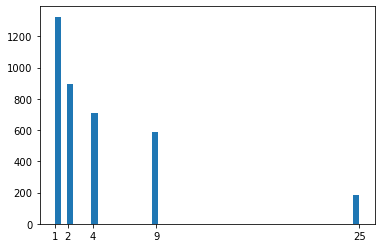

In [54]:
plt.hist(item_price.price, align='mid', bins=50)
plt.xticks(item_price.price.unique())

In [46]:
item_price.groupby('price')['item'].nunique()

price
1     1326
2      896
4      709
9      589
25     186
Name: item, dtype: int64

In [7]:
item_price.describe()

,item,price
count,3706.000000,3706.000000
mean,1852.500000,4.291689
std,1069.974377,5.496992
min,0.000000,1.000000
25%,926.250000,1.000000
50%,1852.500000,2.000000
75%,2778.750000,4.000000
max,3705.000000,25.000000


There are 3706 items with prices distributed from [1, 2, 4, 9, 25].<br>
From the histogram and the data we see that most of the items are priced 2 and lower - ((1: 1326), (2: 896), (4: 709), (9: 589), (25: 186))<br>
It doesn't look like we can deduce a behaviour of a specific distribution (like normal/uniform etc.), especially since we don't have enough data other than ID numbers and prices...<br>

##### B) To evaluate the performance of the price sensitive model we add another metric Revenue@K which measures the overall revenue from the top 5 recommended hits.
Answer:

In [8]:
def revenue_at_K(df, column_name, K):
    ''' For each user: sum the prices of the top K recommended items which were rated as the revenue from the user '''
    result = df.nlargest(K, column_name)
    result_sum = result.sum()
    return result_sum[column_name]


# Calculate the mean revenue from all users

print(revenue_at_K(item_price, 'price', 5))

125


##### C) Suggest a metric of your own which will incorporate both the ranking of the recommended items as well as its price. Explain why this metric is suitable and demonstrate it as part of the evaluation in point e below.
Answer:

##### D) Select one of the models presented in the Neural Collaborative Filtering paper and incorporate the movie price to the loss function as part of training
Answer:

In [9]:
def get_GMF_model(num_users, num_items, latent_dim, regs=None, activation='sigmoid'):
    '''Generalized Matrix Factorization'''

    if not regs:
        regs = [[0,0]]
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                   embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                   embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  #init = init_normal, 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent]) #merge([user_latent, item_latent], mode = 'mul')
    
    # Final prediction layer
    prediction = Dense(1, activation=activation, kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    
    return model

In [14]:
from icecream import ic

def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [0]*((num_negatives + 1)*len(train)),[0]*((num_negatives + 1)*len(train)),[1]
    num_users = train.shape[0]
    all_items = training.item_id.unique().argsort()
    
    negatives = [0]*num_negatives
    labels.extend(negatives)
    total_labels = []
    list(map(lambda x: total_labels.extend(labels), range(len(train))))
#     return
    percent_1 = int(len(train)/100)
    ic(percent_1)
    
    items_the_user_didnt_rank = None
    prev_user = -1
    chosen_item_per_user = []
    for idx_i in range(len(train)):
        curr_index = idx_i * (num_negatives + 1)
        if idx_i != 0 and idx_i % percent_1 == 0:
            print(f'{int(idx_i/percent_1)}%')
        u = train.iloc[idx_i].user_id
        i = train.iloc[idx_i].item_id

        user_input[curr_index:curr_index + (num_negatives + 1)] = [u]*(num_negatives + 1)

        item_input[curr_index] = i
        
        if u != prev_user:
            items = training[training['user_id'] == u].item_id.to_numpy().argsort()
            items_the_user_didnt_rank = all_items[~np.in1d(all_items,items)]
            prev_user = u
#             chosen_item_per_user = []

#         items_the_user_didnt_rank = items_the_user_didnt_rank[~np.in1d(items_the_user_didnt_rank,chosen_item_per_user)]
        sample_items = items_the_user_didnt_rank[np.random.choice(len(items_the_user_didnt_rank), size=num_negatives, replace=False)]
        item_input[curr_index+1:curr_index + (num_negatives + 1)] = sample_items
#         chosen_item_per_user.extend(sample_items)

    return user_input, item_input, total_labels

##### E) 
Answer:

***
## Question 3: Loss function
Cold start or users\items with a small number of interactions is a very common scenario in real world. In this question you will plan how you can leverage content based features to handle the cold start scenario.


A) Answer:

B) Answer:

C) Answer: